In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('Данные_для_курсовои_Классическое_МО.xlsx')

# Исследование данных

In [4]:
print(f"Размерность датасета: {df.shape}")
print("\nТип данных:")
print(df.dtypes.value_counts())
total_nan = df.isnull().sum().sum()
print(f"\nОбщее количество NaN: {total_nan}")
print("\nКоличество дубликатов:")
print(df.duplicated().sum())

Размерность датасета: (1001, 214)

Тип данных:
int64      107
float64    107
Name: count, dtype: int64

Общее количество NaN: 36

Количество дубликатов:
0


### 1. Описательная статистика ключевых переменных

In [7]:
# сводная статистика по ключевым столбцам
print("\nСводная статистика по ключевым столбцам:")
print(df[['IC50, mM', 'CC50, mM', 'SI']].describe())


Сводная статистика по ключевым столбцам:
          IC50, mM     CC50, mM            SI
count  1001.000000  1001.000000   1001.000000
mean    222.805156   589.110728     72.508823
std     402.169734   642.867508    684.482739
min       0.003517     0.700808      0.011489
25%      12.515396    99.999036      1.433333
50%      46.585183   411.039342      3.846154
75%     224.975928   894.089176     16.566667
max    4128.529377  4538.976189  15620.600000


### 2. Проверка на нормальность

In [9]:
# Тест Шапиро-Уилка
for col in ['IC50, mM', 'CC50, mM', 'SI']:
    stat, p = shapiro(df[col])
    print(f'{col}: Statistics={stat:.3f}, p-value={p:.4f}')

IC50, mM: Statistics=0.581, p-value=0.0000
CC50, mM: Statistics=0.807, p-value=0.0000
SI: Statistics=0.070, p-value=0.0000


### 3.	Матрица корреляции Пирсона для целевых показателей

<Axes: >

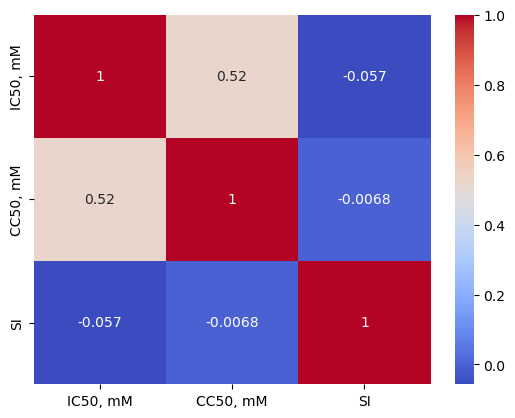

In [11]:
# Матрица корреляций Пирсона для целевых переменных
corr_matrix = df[['IC50, mM', 'CC50, mM', 'SI']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

### 4.	Предварительная обработка данных

In [13]:
# заполняем пропуски медианой
df = df.fillna(df.median())
print(df.shape)
total_nan = df.isnull().sum().sum()
print(f"Общее количество NaN: {total_nan}")

(1001, 214)
Общее количество NaN: 0


In [15]:
# удаление столбцов с нулевой дисперсией (одинаковыми значениями во всех строках)
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
zero_var_cols = [col for col in numeric_cols if df[col].nunique() == 1]
print(f"\nСтолбцы с нулевой дисперсией для удаления ({len(zero_var_cols)}):")
print(zero_var_cols)
df = df.drop(columns=zero_var_cols)


Столбцы с нулевой дисперсией для удаления (18):
['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'fr_N_O', 'fr_SH', 'fr_azide', 'fr_barbitur', 'fr_benzodiazepine', 'fr_diazo', 'fr_dihydropyridine', 'fr_isocyan', 'fr_isothiocyan', 'fr_lactam', 'fr_nitroso', 'fr_phos_acid', 'fr_phos_ester', 'fr_prisulfonamd', 'fr_thiocyan']


### 5.	Анализ целевых переменных

In [17]:
# Топ-10 признаков, коррелирующих с целевыми переменными:
# Для IC50
df.corr()['IC50, mM'].abs().sort_values(ascending=False)[1:11]

CC50, mM        0.521346
VSA_EState4     0.274203
Chi2n           0.257058
PEOE_VSA7       0.255988
Chi2v           0.249164
fr_Ar_NH        0.245511
fr_Nhpyrrole    0.245511
Chi4v           0.243600
Chi4n           0.243497
Chi3n           0.239741
Name: IC50, mM, dtype: float64

In [19]:
# Для CC50
df.corr()['CC50, mM'].abs().sort_values(ascending=False)[1:11]

IC50, mM          0.521346
MolMR             0.310111
LabuteASA         0.309191
MolWt             0.306439
ExactMolWt        0.306382
HeavyAtomCount    0.305169
Chi0              0.304792
Chi1              0.304380
HeavyAtomMolWt    0.303163
Kappa1            0.302206
Name: CC50, mM, dtype: float64

In [21]:
# Для SI
df.corr()['SI'].abs().sort_values(ascending=False)[1:11]

BalabanJ            0.162955
fr_NH2              0.160470
RingCount           0.124444
fr_Al_COO           0.102414
fr_COO2             0.101115
fr_COO              0.101115
NumAromaticRings    0.088064
VSA_EState4         0.087837
FpDensityMorgan1    0.087341
VSA_EState6         0.082995
Name: SI, dtype: float64

Выбросы в IC50: 147
Выбросы в CC50: 39
Выбросы в SI: 125


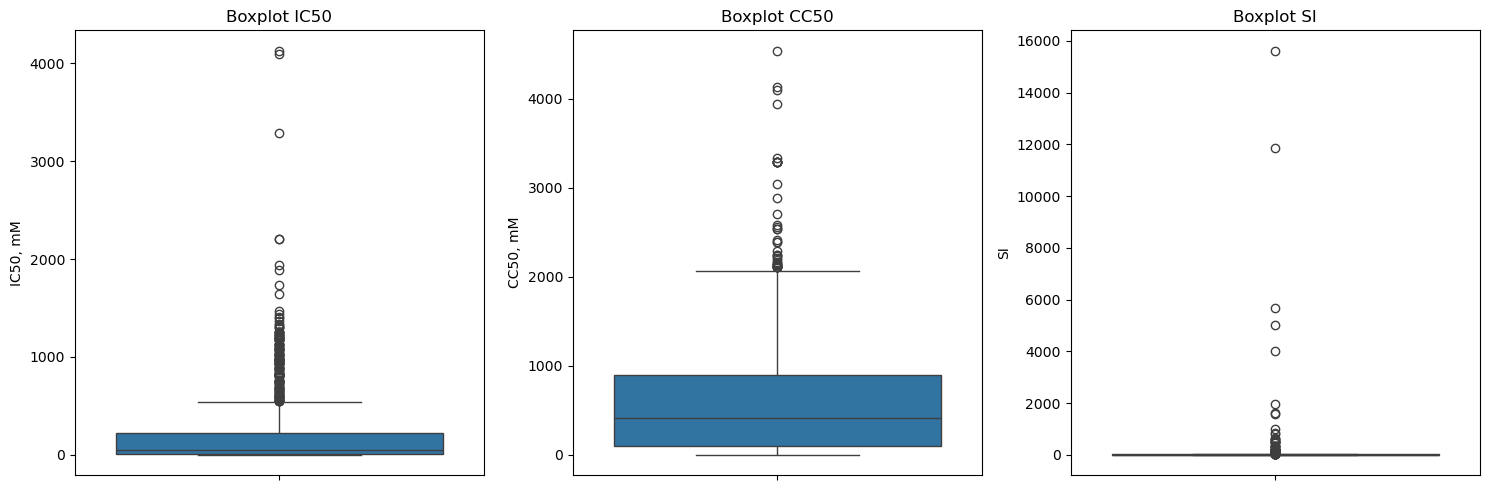

In [23]:
# Функция для обнаружения выбросов с помощью метода IQR
def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)  
    Q3 = df[col].quantile(0.75)  
    IQR = Q3 - Q1  
    lower_bound = Q1 - 1.5 * IQR  
    upper_bound = Q3 + 1.5 * IQR  
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]  
    return outliers

# Обнаружение выбросов в целевых переменных
outliers_ic50 = detect_outliers(df, 'IC50, mM')  
outliers_cc50 = detect_outliers(df, 'CC50, mM')  
outliers_si = detect_outliers(df, 'SI')          

print(f"Выбросы в IC50: {len(outliers_ic50)}")  
print(f"Выбросы в CC50: {len(outliers_cc50)}")  
print(f"Выбросы в SI: {len(outliers_si)}")      

# Визуализация выбросов с помощью графиков 
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y=df['IC50, mM'])  
plt.title('Boxplot IC50')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['CC50, mM'])  
plt.title('Boxplot CC50')

plt.subplot(1, 3, 3)
sns.boxplot(y=df['SI'])       
plt.title('Boxplot SI')

plt.tight_layout()
plt.show()

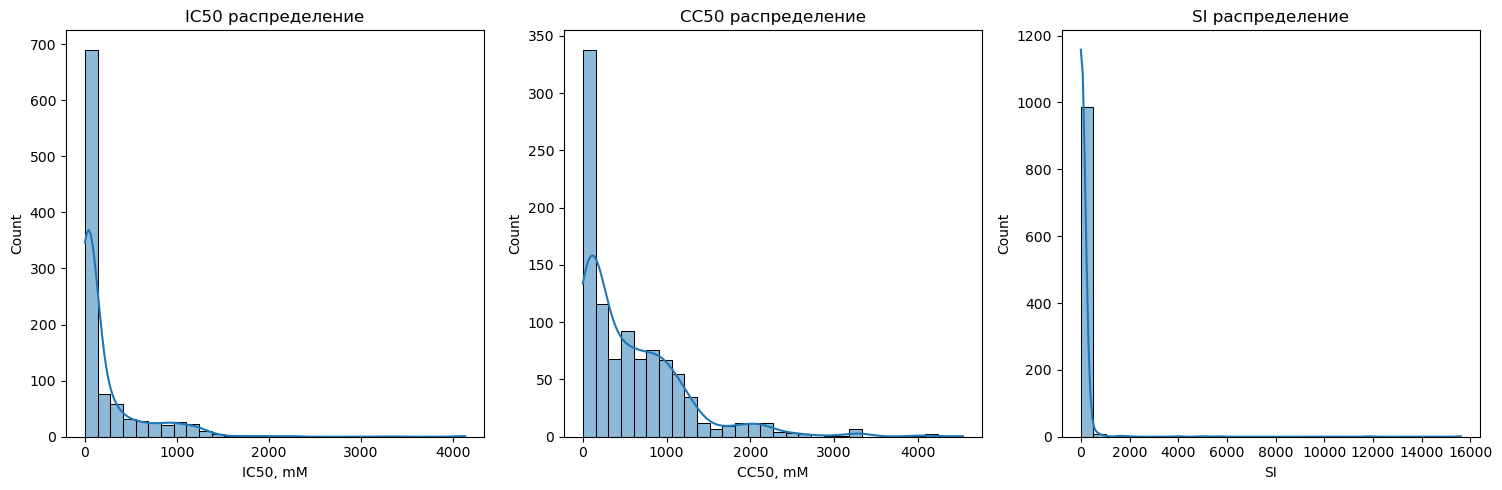

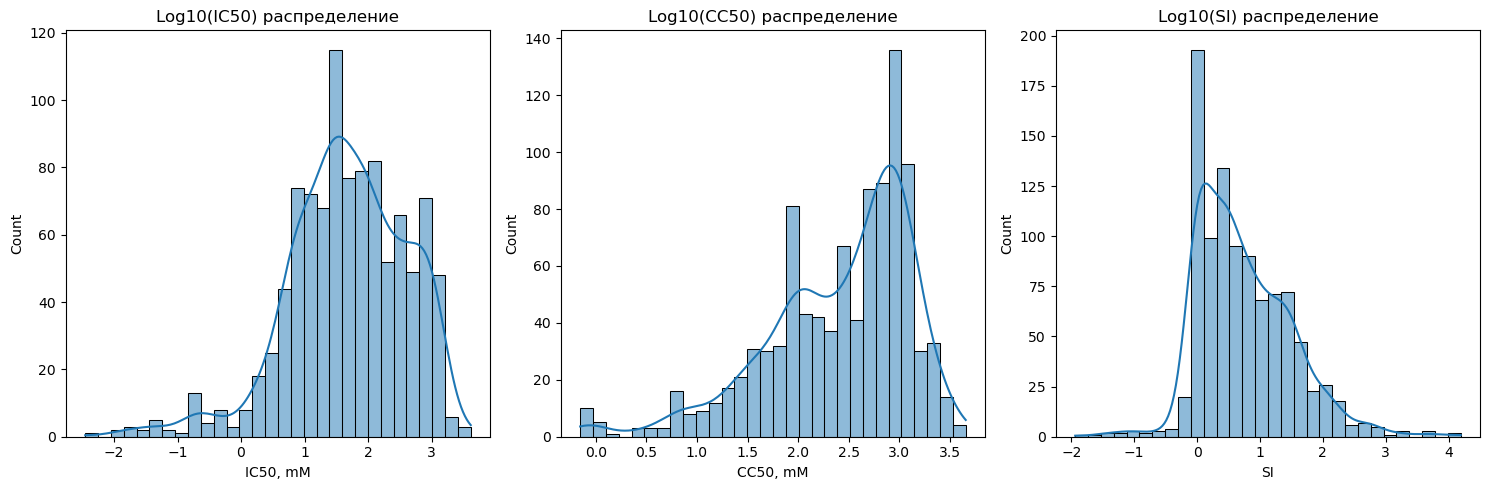

In [25]:
# график распределения целевых переменных
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(df['IC50, mM'], kde=True, bins=30)
plt.title('IC50 распределение')
plt.subplot(1, 3, 2)
sns.histplot(df['CC50, mM'], kde=True, bins=30)
plt.title('CC50 распределение')
plt.subplot(1, 3, 3)
sns.histplot(df['SI'], kde=True, bins=30)
plt.title('SI распределение')
plt.tight_layout()
plt.show()

# логарифмическое преобразование целевых переменных для лучшей визуализации
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(np.log10(df['IC50, mM']), kde=True, bins=30)
plt.title('Log10(IC50) распределение')
plt.subplot(1, 3, 2)
sns.histplot(np.log10(df['CC50, mM']), kde=True, bins=30)
plt.title('Log10(CC50) распределение')
plt.subplot(1, 3, 3)
sns.histplot(np.log10(df['SI']), kde=True, bins=30)
plt.title('Log10(SI) распределение')
plt.tight_layout()
plt.show()

### 6.	Корреляция признаков с целевыми переменными

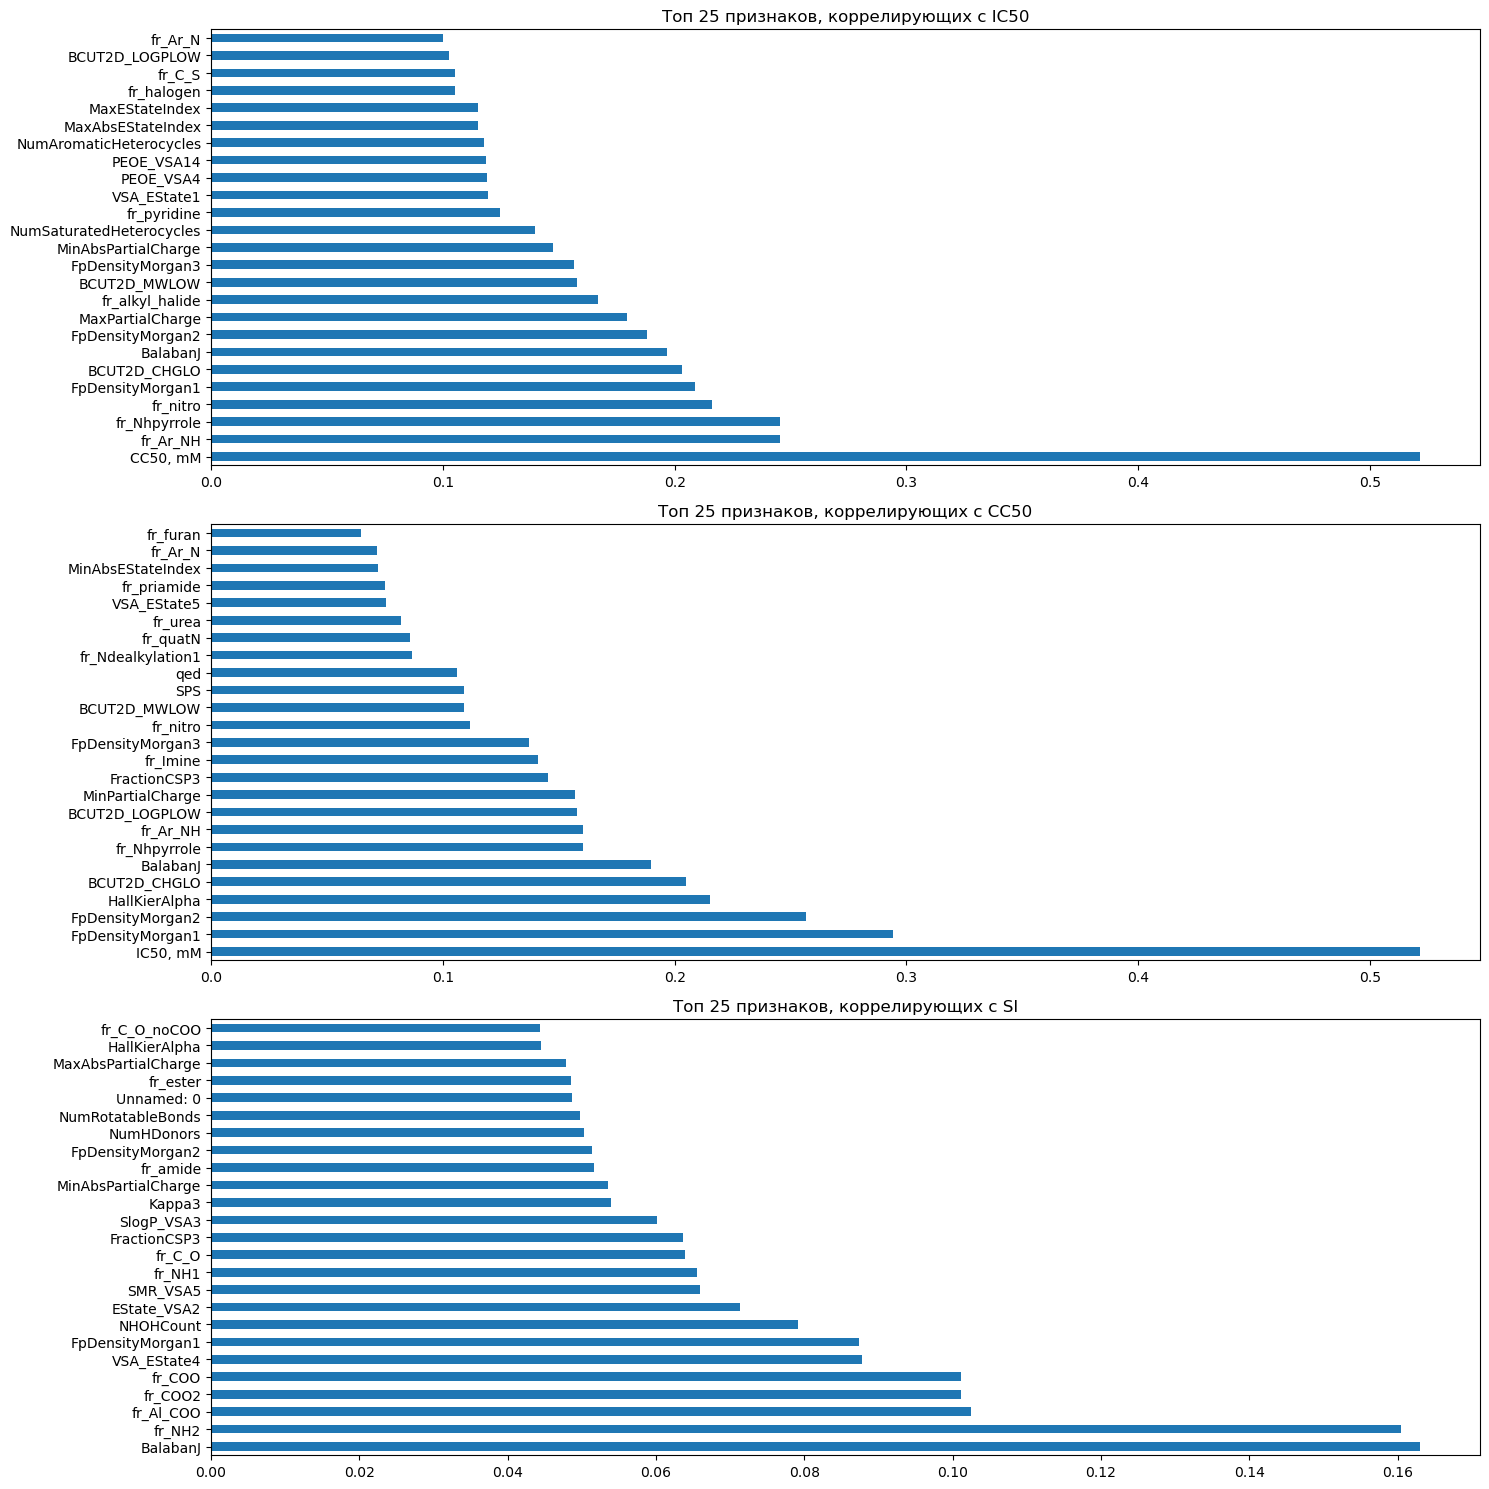

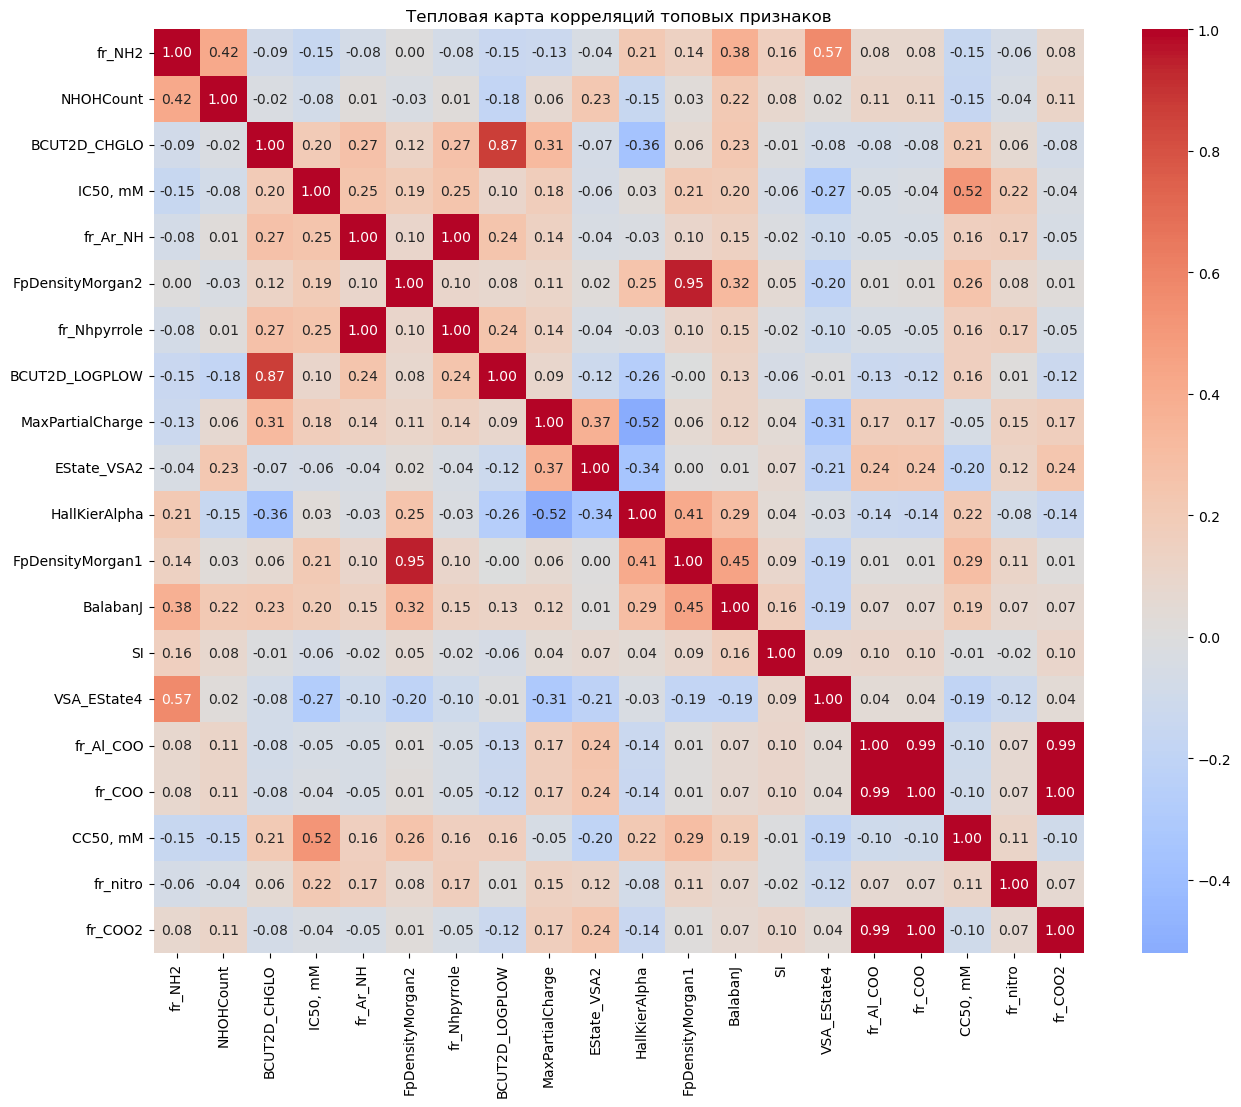

In [27]:
# вычисление корреляции с целевыми переменными
corr_with_ic50 = df.corr()['IC50, mM'].sort_values(ascending=False) 
corr_with_cc50 = df.corr()['CC50, mM'].sort_values(ascending=False)  
corr_with_si = df.corr()['SI'].sort_values(ascending=False)  

# построение графиков топовых признаков по корреляции
plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)
corr_with_ic50[1:26].plot(kind='barh') 
plt.title('Топ 25 признаков, коррелирующих с IC50')

plt.subplot(3, 1, 2)
corr_with_cc50[1:26].plot(kind='barh') 
plt.title('Топ 25 признаков, коррелирующих с CC50')

plt.subplot(3, 1, 3)
corr_with_si[1:26].plot(kind='barh')  
plt.title('Топ 25 признаков, коррелирующих с SI')

plt.tight_layout()
plt.show()

# тепловая карта корреляций для топовых признаков
top_features = list(corr_with_ic50.index[:10]) + list(corr_with_cc50.index[:10]) + list(corr_with_si.index[:10])
top_features = list(set(top_features))  # Удаление дублирующихся признаков

plt.figure(figsize=(15, 12))
sns.heatmap(df[top_features].corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)  # Тепловая карта корреляций
plt.title('Тепловая карта корреляций топовых признаков')
plt.show()

In [41]:
numeric_features = df.select_dtypes(include=np.number)

# анализ корреляционной матрицы
corr_matrix = numeric_features.corr()
# пары признаков с корреляцией выше 0.8 или ниже -0.8
high_corr_pairs = [(col1, col2, corr_matrix.loc[col1, col2])
                   for col1 in corr_matrix.columns for col2 in corr_matrix.columns
                   if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > 0.8]

print("Пары признаков с высокой корреляцией (>0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} и {pair[1]}: корреляция = {pair[2]:.2f}")

# VIF
vif_data = pd.DataFrame()
vif_data['feature'] = numeric_features.columns
vif_data['VIF'] = [variance_inflation_factor(numeric_features.values, i)
                   for i in range(numeric_features.shape[1])]
print("\nПризнаки с высоким VIF (более 5 или 10):")
for index, row in vif_data.iterrows():
    if row['VIF'] > 5:
        print(f"{row['feature']}: VIF = {row['VIF']:.2f}")

Пары признаков с высокой корреляцией (>0.8):
MaxAbsEStateIndex и MaxEStateIndex: корреляция = 1.00
MaxEStateIndex и MaxAbsEStateIndex: корреляция = 1.00
MinEStateIndex и fr_alkyl_halide: корреляция = -0.85
SPS и FractionCSP3: корреляция = 0.85
MolWt и HeavyAtomMolWt: корреляция = 1.00
MolWt и ExactMolWt: корреляция = 1.00
MolWt и NumValenceElectrons: корреляция = 0.98
MolWt и BertzCT: корреляция = 0.90
MolWt и Chi0: корреляция = 0.99
MolWt и Chi0n: корреляция = 0.93
MolWt и Chi0v: корреляция = 0.95
MolWt и Chi1: корреляция = 0.99
MolWt и Chi1n: корреляция = 0.90
MolWt и Chi1v: корреляция = 0.93
MolWt и Kappa1: корреляция = 0.96
MolWt и Kappa2: корреляция = 0.91
MolWt и LabuteASA: корреляция = 0.99
MolWt и HeavyAtomCount: корреляция = 0.99
MolWt и MolMR: корреляция = 0.96
HeavyAtomMolWt и MolWt: корреляция = 1.00
HeavyAtomMolWt и ExactMolWt: корреляция = 1.00
HeavyAtomMolWt и NumValenceElectrons: корреляция = 0.97
HeavyAtomMolWt и BertzCT: корреляция = 0.93
HeavyAtomMolWt и Chi0: коррел